In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split,TimeSeriesSplit,cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

trip=pd.read_csv('D:/Programming languages/Script/database/bikedata/trip_data.csv')
weather=pd.read_csv('D:/Programming languages/Script/database/bikedata/weather_data.csv')
station=pd.read_csv('D:/Programming languages/Script/database/bikedata/station_data.csv') 

In [2]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [4]:
# slice the str for DataFrame
# process speed or memory usage is much more less

start,stop,step=0,-3,1
trip['Start Date']= trip['Start Date'].str.slice(start, stop, step)
trip['End Date']= trip['End Date'].str.slice(start, stop, step)

In [6]:
trip['Start Time']= pd.to_datetime(trip['Start Date'], dayfirst=True).dt.strftime('%Y/%m/%d %H')
trip['End Time']= pd.to_datetime(trip['End Date'], dayfirst=True).dt.strftime('%Y/%m/%d %H')

trip['Start Date']= pd.to_datetime(trip['Start Date'], dayfirst=True).dt.strftime('%Y/%m/%d')
trip['End Date']= pd.to_datetime(trip['End Date'], dayfirst=True).dt.strftime('%Y/%m/%d')

trip['Start Month']= pd.to_datetime(trip['Start Date'], dayfirst=True).dt.strftime('%Y/%m')
trip['End Month']= pd.to_datetime(trip['End Date'], dayfirst=True).dt.strftime('%Y/%m')

In [7]:
#remove two columns, default remove rows
trip=trip.drop(['Trip ID'],axis=1)

In [8]:
#convert from obj to datetime

trip['Count']='1'
trip['Count']=trip['Count'].astype('int64')
trip['Start Station']=trip['Start Station'].astype('str')
trip['Start Time']=pd.to_datetime(trip['Start Time'])
trip['End Time']=pd.to_datetime(trip['End Time'])
trip['End Station']=trip['End Station'].astype('str')
trip['Start Date']=pd.to_datetime(trip['Start Date'])
trip['End Date']=pd.to_datetime(trip['End Date'])
trip['Start Month']=pd.to_datetime(trip['Start Month'])
trip['End Month']=pd.to_datetime(trip['End Month'])

trip.dtypes

Start Date         datetime64[ns]
Start Station              object
End Date           datetime64[ns]
End Station                object
Subscriber Type            object
Start Time         datetime64[ns]
End Time           datetime64[ns]
Start Month        datetime64[ns]
End Month          datetime64[ns]
Count                       int64
dtype: object

In [9]:
# sort by Start Time
trip=trip.sort_values(by='Start Time', ascending=True)

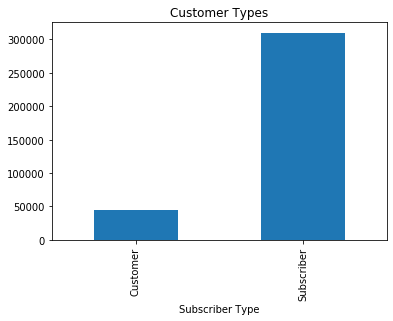

In [10]:
# Preliminary data analysis-----Trip

type=trip.groupby('Subscriber Type')['Start Station'].count()
type.plot.bar(title='Customer Types')

In [11]:
# add week day column
trip['Week day'] = trip['Start Date'].dt.day_name()
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trip['Week day']=trip['Week day'].astype('category')
trip['Week day'].cat.set_categories(cats, inplace=True)
trip.dtypes

Start Date         datetime64[ns]
Start Station              object
End Date           datetime64[ns]
End Station                object
Subscriber Type            object
Start Time         datetime64[ns]
End Time           datetime64[ns]
Start Month        datetime64[ns]
End Month          datetime64[ns]
Count                       int64
Week day                 category
dtype: object

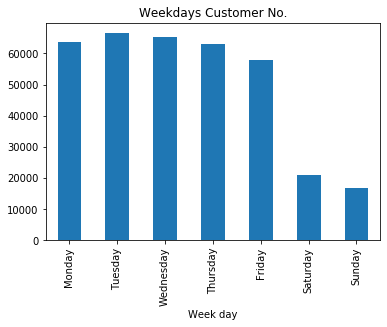

In [12]:
trip.sort_values(["Week day"])
wd=trip.groupby('Week day')['Count'].count()
wd.plot.bar(title='Weekdays Customer No.')

In [13]:
# trip_change = pd.get_dummies(trip)
# trip_change.head()

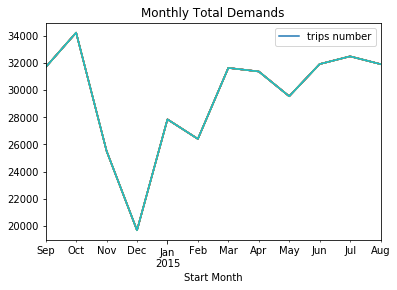

In [14]:
# result=trip.sort_values(by=['Start Station','Start Date'])
Monthly_count=trip.groupby('Start Month').count()
Monthly_count.plot(title='Monthly Total Demands')
plt.legend(['trips number'])

In [15]:
# Preliminary data analysis-----weather


# Weather Monthly reports
weather1=weather.copy()
weather1['Month']= pd.to_datetime(weather1['Date'], dayfirst=True).dt.strftime('%Y/%m')
weather1['Month']=pd.to_datetime(weather1['Month'])
Monthly_weather=weather1.groupby('Month').mean()
Monthly_weather

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Zip
Month,,,,,,,,,,,,,,,,,,,,,
2014-09-01,76.613333,68.206667,59.520000,60.164384,57.164384,53.609589,88.013699,70.917808,50.082192,29.941267,...,11.100000,9.900000,8.253333,17.366667,6.333333,22.728972,0.010773,3.066667,289.080000,94325
2014-10-01,76.600000,65.683871,54.438710,57.947712,52.013072,46.000000,88.405229,65.712418,41.071895,30.031806,...,10.727273,10.077922,8.571429,14.374194,4.845161,20.688679,0.009961,2.154839,279.135484,94325
2014-11-01,66.540000,57.786667,48.780000,53.280576,48.194245,42.676259,91.532374,72.179856,50.107914,30.167000,...,10.540000,9.193333,6.346667,12.546667,3.906667,17.989474,0.030753,3.386667,234.266667,94325
2014-12-01,61.148387,55.238710,48.967742,51.261905,47.341270,43.603175,93.277778,78.714286,61.539683,30.153806,...,10.238710,8.819355,5.393548,15.909677,5.922581,22.887931,0.174819,4.709677,179.529032,94325
2015-01-01,61.722581,52.090323,42.116129,47.529032,43.103226,38.354839,92.322581,73.877419,52.354839,30.234194,...,9.864516,8.341935,5.767742,10.638710,2.800000,14.615385,0.000219,2.406452,241.316129,94325
2015-02-01,66.721429,57.642857,48.221429,52.071429,47.242857,41.900000,89.700000,71.100000,49.964286,30.123000,...,9.964286,9.200000,7.264286,14.507143,5.242857,21.250000,0.045614,3.157143,253.657143,94325
2015-03-01,70.451613,60.045161,49.348387,52.580645,47.703226,42.329032,87.406452,66.348387,42.961290,30.164645,...,10.141935,9.819355,9.006452,15.812903,5.296774,21.154639,0.003000,2.451613,275.303226,94325
2015-04-01,69.160000,59.320000,49.233333,49.226667,44.066667,38.833333,81.980000,61.213333,39.300000,30.078333,...,10.614865,10.054054,9.054054,19.566667,7.653333,23.687500,0.015167,2.393333,277.180000,94325
2015-05-01,66.138158,59.625000,52.789474,50.934211,48.447368,46.078947,83.467105,69.434211,53.572368,30.011161,...,10.516129,10.038710,9.148387,18.935484,8.296774,23.458333,0.007458,4.632258,268.825806,94325


In [16]:
month=['2014-09','2014-10', '2014-11', '2014-12','2015-01', '2015-02', '2015-03', '2015-04','2015-05', '2015-06', '2015-07', '2015-08']

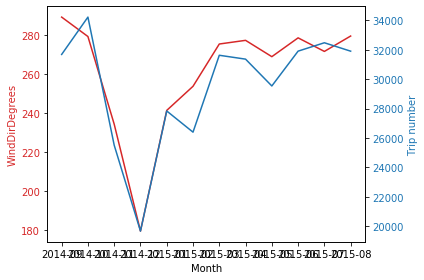

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('WindDirDegrees', color=color)
ax1.plot(month, Monthly_weather['WindDirDegrees'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Trip number', color=color)  # we already handled the x-label with ax1
ax2.plot(month, Monthly_count['Start Date'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

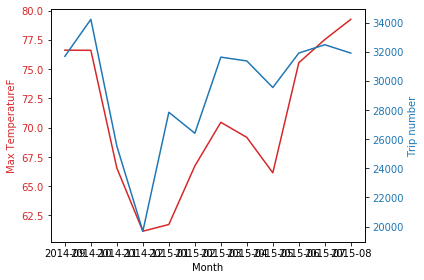

In [18]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Max TemperatureF', color=color)
ax1.plot(month, Monthly_weather['Max TemperatureF'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Trip number', color=color)  # we already handled the x-label with ax1
ax2.plot(month, Monthly_count['Start Date'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [19]:
# merge the two datasets
month_wc=pd.merge(Monthly_count['Count'],Monthly_weather,left_index=True,right_index=True,how='left')
month_wc.drop('Zip',axis=1)

,Count,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
Start Month,,,,,,,,,,,,,,,,,,,,,
2014-09-01,31682,76.613333,68.206667,59.520000,60.164384,57.164384,53.609589,88.013699,70.917808,50.082192,...,29.840600,11.100000,9.900000,8.253333,17.366667,6.333333,22.728972,0.010773,3.066667,289.080000
2014-10-01,34220,76.600000,65.683871,54.438710,57.947712,52.013072,46.000000,88.405229,65.712418,41.071895,...,29.919548,10.727273,10.077922,8.571429,14.374194,4.845161,20.688679,0.009961,2.154839,279.135484
2014-11-01,25516,66.540000,57.786667,48.780000,53.280576,48.194245,42.676259,91.532374,72.179856,50.107914,...,30.042133,10.540000,9.193333,6.346667,12.546667,3.906667,17.989474,0.030753,3.386667,234.266667
2014-12-01,19677,61.148387,55.238710,48.967742,51.261905,47.341270,43.603175,93.277778,78.714286,61.539683,...,30.013097,10.238710,8.819355,5.393548,15.909677,5.922581,22.887931,0.174819,4.709677,179.529032
2015-01-01,27840,61.722581,52.090323,42.116129,47.529032,43.103226,38.354839,92.322581,73.877419,52.354839,...,30.115226,9.864516,8.341935,5.767742,10.638710,2.800000,14.615385,0.000219,2.406452,241.316129
2015-02-01,26401,66.721429,57.642857,48.221429,52.071429,47.242857,41.900000,89.700000,71.100000,49.964286,...,29.995714,9.964286,9.200000,7.264286,14.507143,5.242857,21.250000,0.045614,3.157143,253.657143
2015-03-01,31626,70.451613,60.045161,49.348387,52.580645,47.703226,42.329032,87.406452,66.348387,42.961290,...,30.047742,10.141935,9.819355,9.006452,15.812903,5.296774,21.154639,0.003000,2.451613,275.303226
2015-04-01,31363,69.160000,59.320000,49.233333,49.226667,44.066667,38.833333,81.980000,61.213333,39.300000,...,29.962067,10.614865,10.054054,9.054054,19.566667,7.653333,23.687500,0.015167,2.393333,277.180000
2015-05-01,29540,66.138158,59.625000,52.789474,50.934211,48.447368,46.078947,83.467105,69.434211,53.572368,...,29.927935,10.516129,10.038710,9.148387,18.935484,8.296774,23.458333,0.007458,4.632258,268.825806


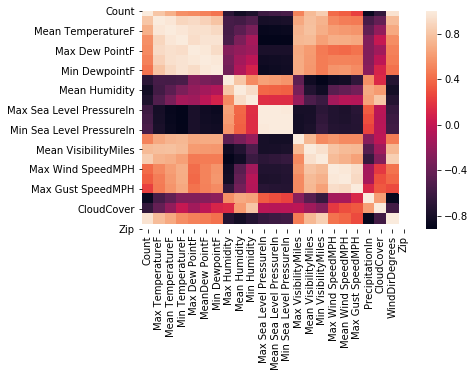

In [20]:
sns.heatmap(month_wc.corr());

(365, 24)


<Figure size 2880x720 with 0 Axes>

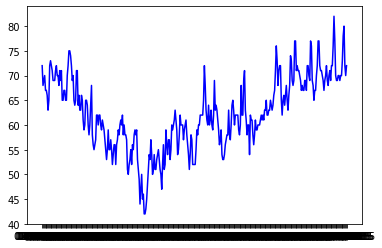

<Figure size 2880x720 with 0 Axes>

In [21]:
Zip= 95113
weather_zip=weather.loc[weather['Zip'] == Zip]
print(weather_zip.shape)

y=weather_zip['Mean TemperatureF']
plt.plot(weather_zip['Date'],y,'b')
plt.figure(figsize=(40,10))

In [22]:
# Preliminary data analysis-----station

code=list(set(station['City']))
temp=code[0]
subset=station[station['City']==temp]
subset

station.describe()

,Id,Lat,Long,Dock Count
count,76.000000,76.000000,76.000000,76.000000
mean,46.513158,37.597618,-122.228385,17.815789
std,26.142427,0.200675,0.205135,4.015671
min,2.000000,37.329732,-122.418954,11.000000
25%,25.750000,37.393338,-122.400824,15.000000
50%,47.500000,37.772936,-122.389138,15.000000
75%,68.250000,37.787475,-122.083233,19.000000
max,90.000000,37.804770,-121.877349,27.000000


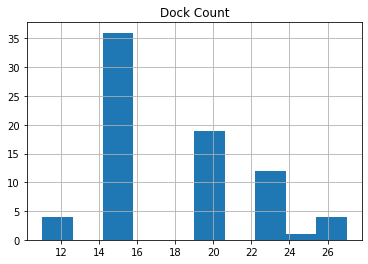

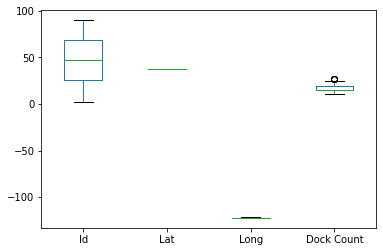

In [23]:
#only numerical datatype can be shown

station.hist('Dock Count')
plt.show()

station.plot(kind='box')
plt.show()

In [24]:
import folium
from folium.plugins import MarkerCluster

def color(group):
    if group==code[0]:
        col='green'
    elif group==code[1]:
        col='black'
    elif group==code[2]:
        col='red'
    elif group==code[3]:
        col='blue'
    else:
        col='yellow'
    return col

cluster_map = folium.Map(location=[37.443988,-122.164759], zoom_start=9, control_scale=True)

for m in range(len(station)):
    folium.Marker(location=[station['Lat'][m],station['Long'][m]],
                  popup = str(m+1),
                  icon=folium.Icon(color=color(station['City'][m])),
                  clustered_marker=True).add_to(cluster_map)

cluster_map

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:22: UserWarning: color argument of Icon should be one of: {'blue', 'green', 'darkgreen', 'lightblue', 'darkblue', 'darkred', 'orange', 'black', 'lightred', 'white', 'gray', 'pink', 'lightgray', 'darkpurple', 'cadetblue', 'lightgreen', 'purple', 'red', 'beige'}.


In [25]:
# # use PCA to filter the attributes for weather, regarding events 0=no event 1=special events as y
# # use logistic regression to predict the weather, then link the weather with the bike rental rate

In [26]:
# This is 1-many case. We keep all the events as y.

weather['event']=weather['Events']
weather['event'].loc[weather['event'].isnull()] = 'Clear'

D:\Programming languages\anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
weather['Date']= pd.to_datetime(weather['Date'], dayfirst=True).dt.strftime('%Y-%m-%d')

In [28]:
# prepare for future merge
weather_0=weather[['Date','event','Zip']]

In [29]:
weather_1=weather.drop(['Date','Events','Zip'],axis=1).replace(np.nan, 0, regex=True)
y=weather_1.event
X=weather_1.drop(['event'], axis=1).astype('float64')

In [30]:
# test the optimal components number
logistic = LogisticRegression()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
X_pca = pca.fit_transform(scale(X))
X_pca.shape

(1825, 21)

Text(0, 0.5, 'explained_variance_')

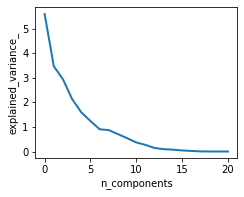

In [31]:
pca.fit(X_pca)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [32]:
# classification(logistic regression) is not time-series sensitive, so can use train_test_split


train_x, test_x, train_y, test_y = train_test_split(X_pca,y, test_size=0.2, random_state=0)

In [33]:
# 95% can be explained
pca = PCA(.95)
pca.fit(train_x)
train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

In [34]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs')
clf=logisticRegr.fit(train_x, train_y)
# Predict for One Observation
logisticRegr.predict(test_x[0].reshape(1,-1))

# Predict for One Observation
prediction=logisticRegr.predict(test_x)
# Measuring Model Performance
logisticRegr.score(test_x, test_y)

D:\Programming languages\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9123287671232877

In [43]:

trip_demand=trip[['Start Time','Start Station','Count']]
# sum only sum up type of column which is int
trip_demand=trip_demand.groupby(['Start Station','Start Time'], as_index=False).sum()

trip_supply=trip[['End Time','End Station','Count']]
trip_supply=trip_supply.groupby(['End Station','End Time'], as_index=False).sum()
# without as_index=False, multiindex by using above function


In [45]:
# data types should be converted first(Start Station must be str, Start Date should be datetime64) 
# otherwise it could not be processed
trip_demand=trip_demand.groupby('Start Station').apply(lambda x : x.set_index('Start Time').resample('H').mean().fillna(0)).reset_index()

trip_supply=trip_supply.groupby('End Station').apply(lambda y : y.set_index('End Time').resample('H').mean().fillna(0)).reset_index()

In [46]:
#output to check the problem
trip_demand.to_csv(r'D:/Programming languages/Script/database/bikedata/trip.csv')

In [47]:
trip_demand.head()

,Start Station,Start Time,Count
0,10,2014-09-02 06:00:00,1.0
1,10,2014-09-02 07:00:00,0.0
2,10,2014-09-02 08:00:00,1.0
3,10,2014-09-02 09:00:00,0.0
4,10,2014-09-02 10:00:00,0.0


In [49]:
# merge the two datasets, should use 'left' instead of 'outer'
comb=pd.merge(trip_demand,trip_supply,left_on=['Start Station', 'Start Time'],right_on=['End Station', 'End Time'],how='left')

# drop multiple columns
comb=comb.drop(['End Station', 'End Time'], axis=1)

In [50]:
# rename the columns
comb=comb.rename(columns={'Start Station': 'Station', 'Start Time': 'Time', 'Count_x':'trip_demand','Count_y':'trip_supply'})

# fill the NaN with 0
comb=comb.fillna(0)

# add gap column
comb['diff']=comb['trip_supply']-comb['trip_demand']


comb.head()

,Station,Time,trip_demand,trip_supply,diff
0,10,2014-09-02 06:00:00,1.0,0.0,-1.0
1,10,2014-09-02 07:00:00,0.0,1.0,1.0
2,10,2014-09-02 08:00:00,1.0,3.0,2.0
3,10,2014-09-02 09:00:00,0.0,0.0,0.0
4,10,2014-09-02 10:00:00,0.0,0.0,0.0


In [51]:
comb['Date']=comb['Time'].astype('str')

s,e,gap=0,-9,1
comb['Date']= comb['Date'].str.slice(s, e, gap)

comb.tail()

,Station,Time,trip_demand,trip_supply,diff,Date
609492,90,2015-08-31 16:00:00,3.0,3.0,0.0,2015-08-31
609493,90,2015-08-31 17:00:00,2.0,7.0,5.0,2015-08-31
609494,90,2015-08-31 18:00:00,1.0,1.0,0.0,2015-08-31
609495,90,2015-08-31 19:00:00,0.0,4.0,4.0,2015-08-31
609496,90,2015-08-31 20:00:00,1.0,0.0,-1.0,2015-08-31


In [52]:
# merge the two datasets
comb_cw=pd.merge(comb,weather_0,on='Date',how='outer')

In [53]:
comb_cw

,Station,Time,trip_demand,trip_supply,diff,Date,event,Zip
0,10,2014-09-02 06:00:00,1.0,0.0,-1.0,2014-09-02,Clear,94107
1,10,2014-09-02 06:00:00,1.0,0.0,-1.0,2014-09-02,Clear,94063
2,10,2014-09-02 06:00:00,1.0,0.0,-1.0,2014-09-02,Clear,94301
3,10,2014-09-02 06:00:00,1.0,0.0,-1.0,2014-09-02,Clear,94041
4,10,2014-09-02 06:00:00,1.0,0.0,-1.0,2014-09-02,Clear,95113
...,...,...,...,...,...,...,...,...
3047480,9,2014-09-01 23:00:00,0.0,0.0,0.0,2014-09-01,Clear,94107
3047481,9,2014-09-01 23:00:00,0.0,0.0,0.0,2014-09-01,Clear,94063
3047482,9,2014-09-01 23:00:00,0.0,0.0,0.0,2014-09-01,Clear,94301
3047483,9,2014-09-01 23:00:00,0.0,0.0,0.0,2014-09-01,Clear,94041


In [54]:
station['Zip']='' # give it a blank to set up a column

In [55]:
for z in range(len(station)):
    if station['City'][z]=='San Jose': station['Zip'][z]='95113'
    if station['City'][z]=='San Francisco': station['Zip'][z]='94107'
    if station['City'][z]=='Redwood City': station['Zip'][z]='94063'
    if station['City'][z]=='Palo Alto': station['Zip'][z]='94301'
    if station['City'][z]=='Mountain View': station['Zip'][z]='94041'

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Programming languages\anaconda

In [56]:
#combine three datasets

station['Id']=station['Id'].astype('str')
terminal=pd.merge(station,comb,left_on='Id',right_on='Station',how='outer')

weather_0['Zip']=weather_0['Zip'].astype('str')
final=pd.merge(terminal,weather_0, on=['Date','Zip'],how='outer')

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
final=final.dropna(subset=['Id', 'Station'])

In [58]:
entire=final[['Id','Name','Zip','City','Dock Count','event','Time','trip_demand','trip_supply','diff']]

In [59]:
entire['event_num']=entire['event']
event_num = {'Clear': 0,'Fog': 1, 'Fog-Rain':2, 'Rain':3,'Rain-Thunderstorm':4 } 
entire.event_num = [event_num[item] for item in entire.event_num] 

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming languages\anaconda\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [60]:
# check how many unique values in a column

entire.event_num.unique()

array([0, 3, 1, 2, 4], dtype=int64)

In [63]:
entire.tail()

,Id,Name,Zip,City,Dock Count,event,Time,trip_demand,trip_supply,diff,event_num
609492,82,Broadway St at Battery St,94107,San Francisco,15.0,Clear,2015-08-31 15:00:00,2.0,1.0,-1.0,0
609493,82,Broadway St at Battery St,94107,San Francisco,15.0,Clear,2015-08-31 16:00:00,3.0,2.0,-1.0,0
609494,82,Broadway St at Battery St,94107,San Francisco,15.0,Clear,2015-08-31 17:00:00,5.0,0.0,-5.0,0
609495,82,Broadway St at Battery St,94107,San Francisco,15.0,Clear,2015-08-31 18:00:00,5.0,0.0,-5.0,0
609496,82,Broadway St at Battery St,94107,San Francisco,15.0,Clear,2015-08-31 19:00:00,1.0,0.0,-1.0,0


In [66]:
ana=entire[['Id','Time','City','event_num','trip_demand','trip_supply','diff']]
ana['Time']=ana['Time'].astype('datetime64')

D:\Programming languages\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
ana.head()

,Id,Time,City,event_num,trip_demand,trip_supply,diff
0,2,2014-09-01 12:00:00,San Jose,0,1.0,0.0,-1.0
1,2,2014-09-01 13:00:00,San Jose,0,0.0,0.0,0.0
2,2,2014-09-01 14:00:00,San Jose,0,0.0,1.0,1.0
3,2,2014-09-01 15:00:00,San Jose,0,0.0,0.0,0.0
4,2,2014-09-01 16:00:00,San Jose,0,0.0,0.0,0.0


In [68]:
ana=ana.groupby(['City','Time'], as_index=False).sum()

In [69]:
ana.head()

,City,Time,event_num,trip_demand,trip_supply,diff
0,Mountain View,2014-09-01 07:00:00,0,2.0,0.0,-2.0
1,Mountain View,2014-09-01 08:00:00,0,0.0,0.0,0.0
2,Mountain View,2014-09-01 09:00:00,0,0.0,0.0,0.0
3,Mountain View,2014-09-01 10:00:00,0,1.0,0.0,-1.0
4,Mountain View,2014-09-01 11:00:00,0,0.0,0.0,0.0


In [70]:
ana.City.unique()

array(['Mountain View', 'Palo Alto', 'Redwood City', 'San Francisco',
       'San Jose'], dtype=object)

In [71]:
City=str(input('Enter the City'))

Enter the CitySan Francisco


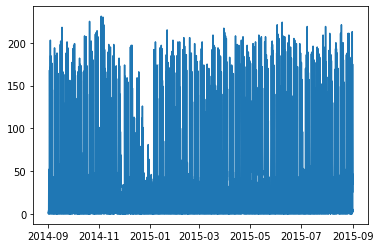

In [72]:
# use input station no at first

# attention to the data type for input

if str(City) in ana.City.unique(): 
    # use iloc or loc to select the requested data from dataset, like SQL
    seg_city = ana.loc[ana['City'] == City]
    # plot for this station
    plt.plot(seg_city['Time'], seg_city['trip_demand'])
else:
    print('Invalid input. Try again!')

In [74]:
# methods 1: time series
# set time as index and convert trip_in out to int in order to observe daily or even hourly changes.

ts=seg_city[['Time','trip_demand']]
ts.set_index('Time', inplace=True)
len(ts)

8760

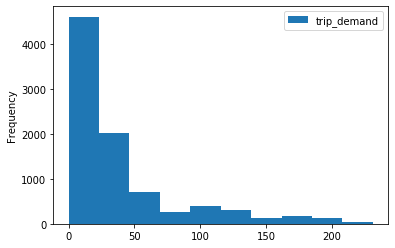

In [75]:
ts.plot.hist()

#from the plot, we can find out it follows exponential distribution, this is discrete distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001369D7F9808>]],
      dtype=object)

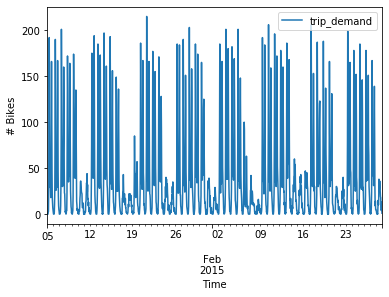

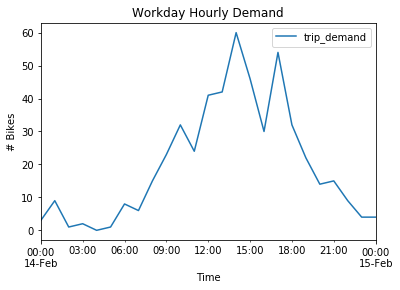

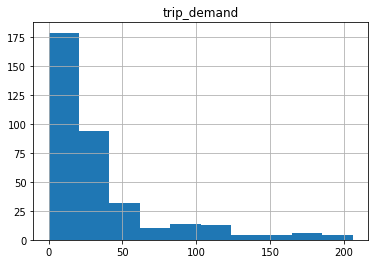

In [76]:
ts.loc['2015-01-05':'2015-02-28'].plot(kind='line')
plt.ylabel('# Bikes')

ts.loc['2015-02-14 00:00:00':'2015-02-15 00:00:00'].plot(title='Workday Hourly Demand')
plt.ylabel('# Bikes')

ts.loc['2015-02-14':'2015-02-28'].hist()

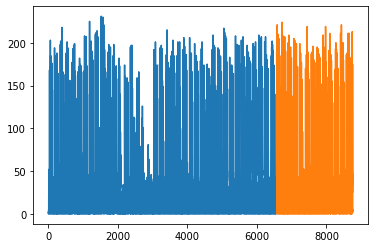

In [77]:
# 7 major time series models

train_test_split = 0.75
split = train_test_split * len(ts)

train=ts[:int(split)]
test=ts[int(split):]

plt.plot(range(len(train)),train,'-')
plt.plot(range(len(train),len(ts)),test,'-')

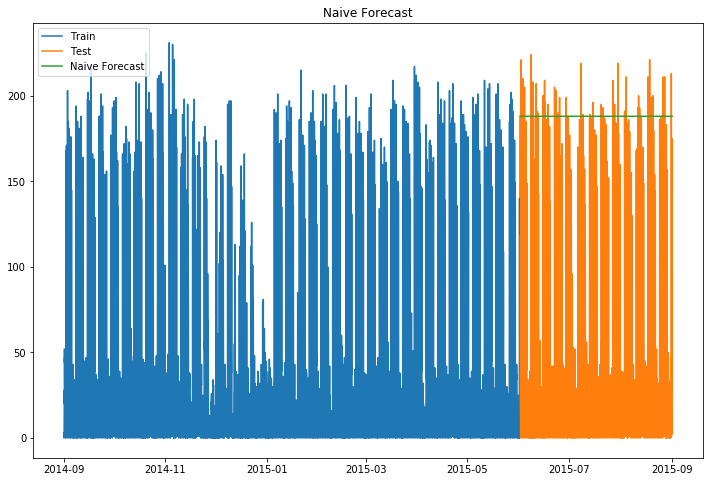

149.43287671232878
24529.044748858447
156.61751099049698


In [78]:
#Yt+1=Yt: infeasible in this example, because of 0 value

dd = np.asarray(train['trip_demand'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd) - 1]
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['trip_demand'], label='Train')
plt.plot(test.index, test['trip_demand'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

rms_naive = sqrt(mean_squared_error(test['trip_demand'], y_hat['naive']))

from sklearn import metrics
print(metrics.mean_absolute_error(test['trip_demand'], y_hat['naive']))
print(metrics.mean_squared_error(test['trip_demand'], y_hat['naive']))
print(rms_naive)

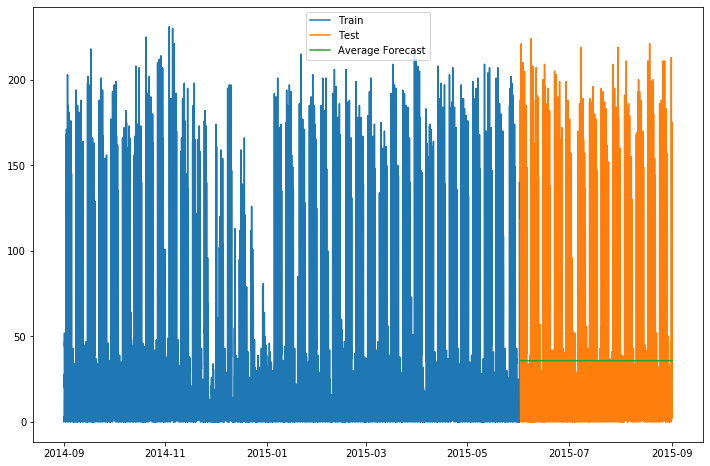

34.506627885156696
2368.875056191489
48.671090558888125


In [79]:
# Simple Average

y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['trip_demand'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['trip_demand'], label='Train')
plt.plot(test['trip_demand'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()


rms_simple = sqrt(mean_squared_error(test['trip_demand'], y_hat_avg['avg_forecast']))
print(metrics.mean_absolute_error(test['trip_demand'], y_hat_avg['avg_forecast']))
print(metrics.mean_squared_error(test['trip_demand'],y_hat_avg['avg_forecast']))
print(rms_simple)

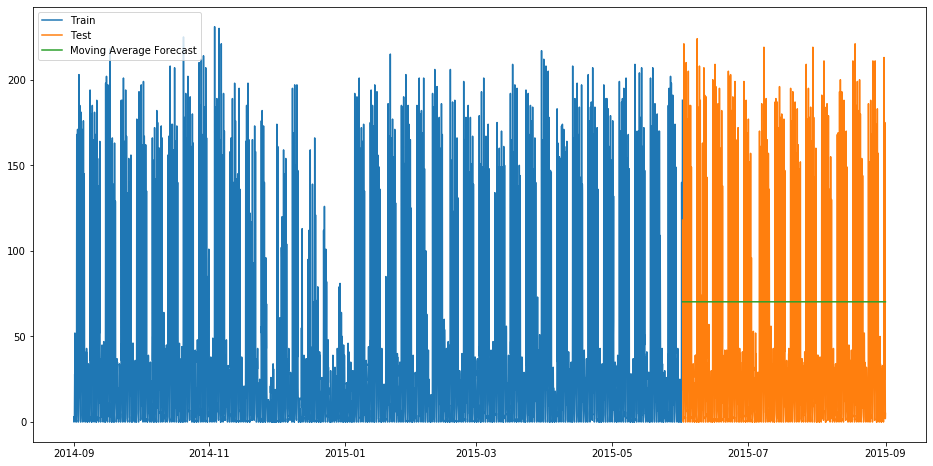

-0.4114237956191109
52.61643835616438
3328.4798515981734
57.692979222763086


In [80]:
#Moving Average

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['trip_demand'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['trip_demand'], label='Train')
plt.plot(test['trip_demand'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

print(metrics.r2_score(test['trip_demand'],y_hat_avg['moving_avg_forecast']))
rms_moving = sqrt(mean_squared_error(test['trip_demand'], y_hat_avg['moving_avg_forecast']))
print(metrics.mean_absolute_error(test['trip_demand'],  y_hat_avg['moving_avg_forecast']))
print(metrics.mean_squared_error(test['trip_demand'], y_hat_avg['moving_avg_forecast']))
print(rms_moving)

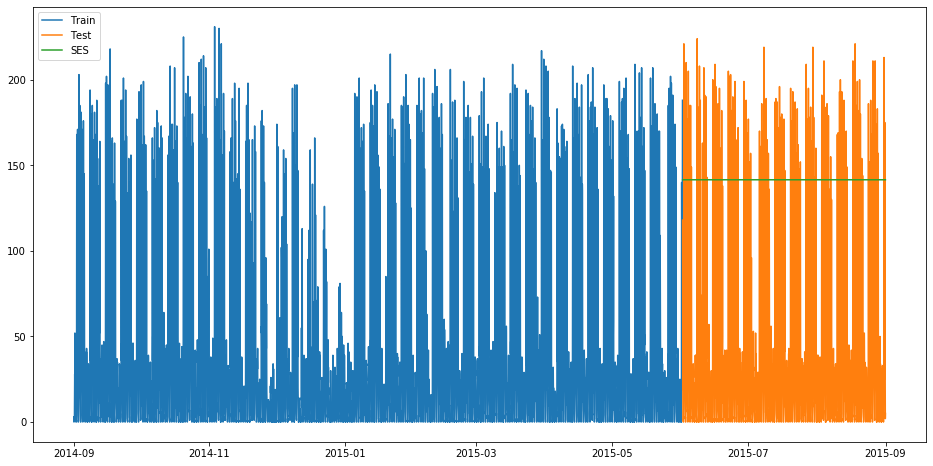

-4.451125295273939
106.98598424574277
12855.076391777662
113.380229280848


In [81]:
# Simple moving smoothing exponential

from statsmodels.tsa.api import SimpleExpSmoothing

y_hat_avg = test.copy()
fit = SimpleExpSmoothing(np.asarray(train['trip_demand'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit.forecast(len(test))
plt.figure(figsize=(16, 8))
plt.plot(train['trip_demand'], label='Train')
plt.plot(test['trip_demand'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

print(metrics.r2_score(test['trip_demand'],y_hat_avg['SES']))
rms_smooth = sqrt(mean_squared_error(test['trip_demand'], y_hat_avg['SES']))
print(metrics.mean_absolute_error(test['trip_demand'],  y_hat_avg['SES']))
print(metrics.mean_squared_error(test['trip_demand'], y_hat_avg['SES']))
print(rms_smooth)

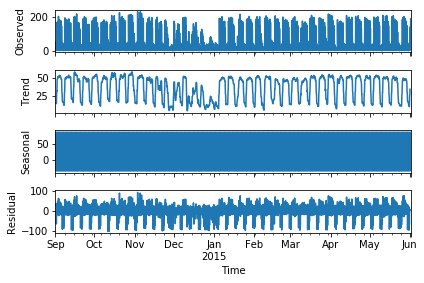

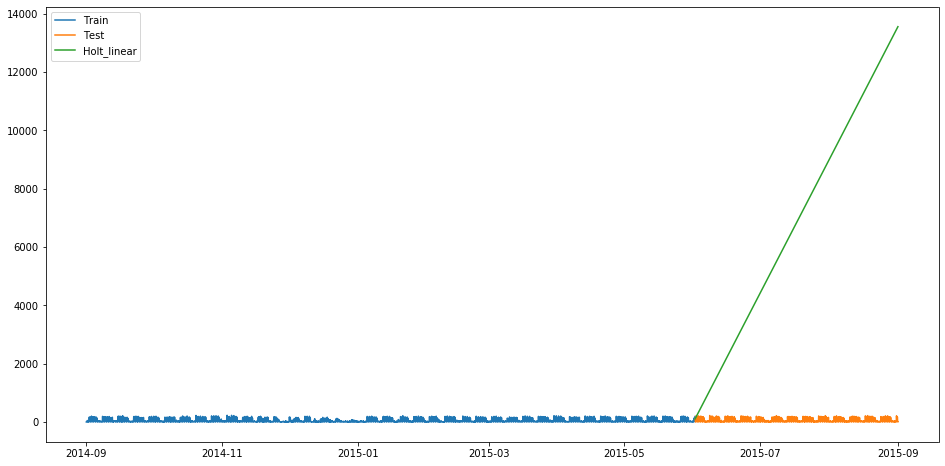

6789.393871737181
61167094.24379512
7820.939473221559


In [82]:
# Holt

import statsmodels.api as sm
sm.tsa.seasonal_decompose(train['trip_demand']).plot()
result = sm.tsa.stattools.adfuller(train['trip_demand'])
plt.show()


from statsmodels.tsa.api import Holt
y_hat_avg = test.copy()
fit = Holt(np.asarray(train['trip_demand'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit.forecast(len(test))
plt.figure(figsize=(16, 8))
plt.plot(train['trip_demand'], label='Train')
plt.plot(test['trip_demand'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()


rms_holt = sqrt(mean_squared_error(test['trip_demand'], y_hat_avg['Holt_linear']))
print(metrics.mean_absolute_error(test['trip_demand'],  y_hat_avg['Holt_linear']))
print(metrics.mean_squared_error(test['trip_demand'], y_hat_avg['Holt_linear']))
print(rms_holt)

D:\Programming languages\anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


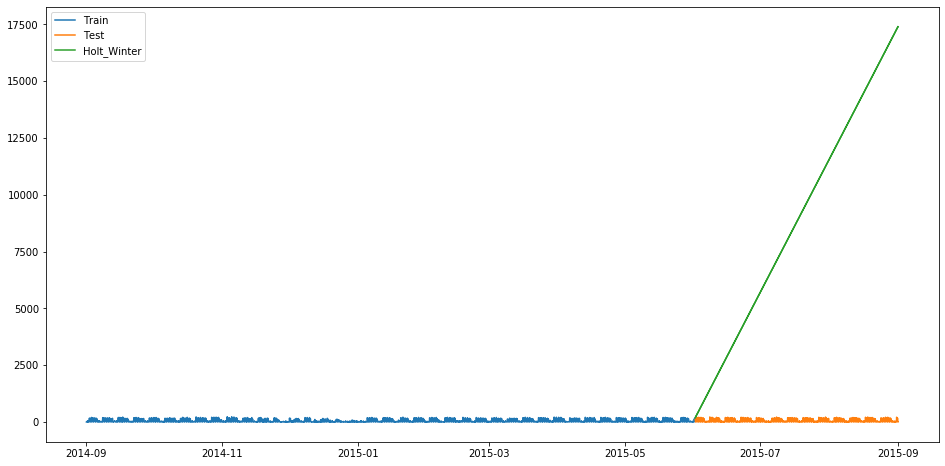

8756.054335241972
101376834.68959972
10068.606392624539


In [83]:
# Holt-Winter Seasonal Factor

from statsmodels.tsa.api import ExponentialSmoothing
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['trip_demand']), seasonal_periods=4, trend='add', seasonal='add', ).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16, 8))
plt.plot(train['trip_demand'], label='Train')
plt.plot(test['trip_demand'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

rms_winter = sqrt(mean_squared_error(test['trip_demand'], y_hat_avg['Holt_Winter']))
print(metrics.mean_absolute_error(test['trip_demand'],   y_hat_avg['Holt_Winter']))
print(metrics.mean_squared_error(test['trip_demand'],  y_hat_avg['Holt_Winter']))
print(rms_winter)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=61708.694, BIC=61749.436, Fit time=11.683 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=68738.097, BIC=68751.677, Fit time=0.177 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=63468.217, BIC=63488.587, Fit time=0.521 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=63478.526, BIC=63498.897, Fit time=2.559 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=71936.598, BIC=71943.388, Fit time=0.099 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=61706.696, BIC=61740.647, Fit time=7.584 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=61894.068, BIC=61921.229, Fit time=5.121 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=61835.682, BIC=61862.843, Fit time=3.185 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=61708.694, BIC=61749.436, Fit time=6.997 seconds
Fit ARIMA: order=(

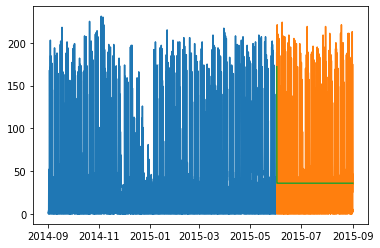

34.524550758978044
2368.04812478166
48.66259471895904


In [84]:
# auto ARIMA

# For non-stationary time series, we set ‘d’ parameter as 1. Also, 
# the value of the auto-regressive trend parameter ‘p’ and the moving average trend parameter ‘q’, 
# is calculated on the stationary time series i.e by plotting ACP and PACP after differencing the time series.

from pmdarima.arima import auto_arima # use the new module pmdarima instead of pyramid.arima

model = auto_arima(train['trip_demand'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['trip_demand'])

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train['trip_demand'], label='train')
plt.plot(test['trip_demand'], label='test')
plt.plot(forecast, label='Prediction')
plt.show()


rms_arima = sqrt(mean_squared_error(test['trip_demand'],forecast))
print(metrics.mean_absolute_error(test['trip_demand'],forecast))
print(metrics.mean_squared_error(test['trip_demand'],forecast))
print(rms_arima)

In [85]:
metrics.r2_score(test['trip_demand'],forecast)

-0.004157940413318073

In [86]:
forecast

,Prediction
Time,
2015-06-01 18:00:00,171.999109
2015-06-01 19:00:00,104.868194
2015-06-01 20:00:00,60.874281
2015-06-01 21:00:00,44.932155
2015-06-01 22:00:00,39.155189
...,...
2015-08-31 19:00:00,35.872079
2015-08-31 20:00:00,35.872079
2015-08-31 21:00:00,35.872079
